In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv("input_edp.csv")
df

APPLICATION NAME dataset  Mem-footprint   mem-read  mem-write  \
0            b+tree dataset1         93.456  15.509967   1.554145   
1            b+tree dataset2        116.070  21.140944   1.288547   
2            b+tree dataset3        138.972  22.897899   1.203390   
3          backprop dataset1         12.253  26.741349  14.551835   
4          backprop dataset2         24.503  26.742664  14.555617   
..                       ...            ...        ...        ...   
287  srad_v2_20iter dataset5      28673.029  25.437290  13.701746   
288   streamcluster dataset1         69.341  28.468167   0.434341   
289   streamcluster dataset2         69.341  28.468088   0.435377   
290   streamcluster dataset3         69.341  28.468053   0.433194   
291   streamcluster dataset4         69.341  28.468054   0.435573   

     control-flow  arithmetic  floating-point     stack     shift    string  \
0       27.829952   54.941873    1.722007e-07  0.571198  0.175559  0.000057   
1       24.880900   60.447711    8.213758e-08  0.436424  2.084063  0.000028   
2       23.928920   62.185153    5.375183e-08  0.395748  2.679336  0.000018   
3       21.377851   58.318274    8.033509e-06  2.643034  1.935624  0.004546   
4       21.377783   58.309787    4.021758e-06  2.641224  1.935444  0.002276   
..            ...         ...             ...       ...       ...       ...   
287     20.319989   54.552855    8.479929e-10  1.531623  2.442938  0.000008   
288     14.568681   43.393089    0.000000e+00  0.149160  0.225942  0.000021   
289     14.568831   43.393947    0.000000e+00  0.149570  0.226564  0.000021   
290     14.568987   43.392441    0.000000e+00  0.148703  0.225248  0.000021   
291     14.568964   43.394183    0.000000e+00  0.149647  0.226681  0.000021   

     ...  Coef-IW  Coef-SIMD   Coef-BW  Coef-cores  Max-su-threads  \
0    ...      1.5          4  4.222548    3.428571              28   
1    ...      1.5          4  4.222548    3.428571              56   
2    ...      1.5          4  4.222548    3.428571              28   
3    ...      1.5          4  4.222548    3.428571              28   
4    ...      1.5          4  4.222548    3.428571              28   
..   ...      ...        ...       ...         ...             ...   
287  ...      1.0          4  2.815520    3.200000              40   
288  ...      1.0          4  2.815520    3.200000              40   
289  ...      1.0          4  2.815520    3.200000              40   
290  ...      1.0          4  2.815520    3.200000              40   
291  ...      1.0          4  2.815520    3.200000              40   

           Cpu-EDP  threads       Gpu-EDP         WG  cpu0-gpu1  
0         0.000693       28  3.731571e+00        256          0  
1         0.599295       56  8.542721e+00       1024          0  
2         0.785423       28  2.717129e+00         96          0  
3         0.007895       28  8.908564e+00      16x16          0  
4         0.019690       28  1.361252e+00      16x16          0  
..             ...      ...           ...        ...        ...  
287  904353.298000       40  1.792718e+06  (32-32-1)          0  
288    4603.897560       40  2.165727e+03        512          1  
289   18942.307100       40  6.327343e+06        512          0  
290   38731.499500       40  2.229455e+07        512          0  
291   74705.894500       40  5.219568e+07        512          0  

[292 rows x 73 columns]

# Model 1: MICA only

# Format data: Split data into Dependent and Independent

In [3]:
#base set
X = df.drop(['APPLICATION NAME dataset','arch1','Issue-width1','SIMD-width','cores1','Mem_BW1','arch2','Issue-width2','Num_SMs','cores2','Mem_bw2','ILP rate','itod','mRD1k-32k','mRD32k-oo','mrgs32k-oo','Coef-IW','Coef-BW','Coef-SIMD','Coef-cores','Max-su-threads','Cpu-EDP','threads','Gpu-EDP','WG','cpu0-gpu1'],axis='columns').copy()
X

Mem-footprint   mem-read  mem-write  control-flow  arithmetic  \
0           93.456  15.509967   1.554145     27.829952   54.941873   
1          116.070  21.140944   1.288547     24.880900   60.447711   
2          138.972  22.897899   1.203390     23.928920   62.185153   
3           12.253  26.741349  14.551835     21.377851   58.318274   
4           24.503  26.742664  14.555617     21.377783   58.309787   
..             ...        ...        ...           ...         ...   
287      28673.029  25.437290  13.701746     20.319989   54.552855   
288         69.341  28.468167   0.434341     14.568681   43.393089   
289         69.341  28.468088   0.435377     14.568831   43.393947   
290         69.341  28.468053   0.433194     14.568987   43.392441   
291         69.341  28.468054   0.435573     14.568964   43.394183   

     floating-point     stack     shift    string        sse  ...  \
0      1.722007e-07  0.571198  0.175559  0.000057   0.002932  ...   
1      8.213758e-08  0.436424  2.084063  0.000028   0.053417  ...   
2      5.375183e-08  0.395748  2.679336  0.000018   0.069909  ...   
3      8.033509e-06  2.643034  1.935624  0.004546   5.704431  ...   
4      4.021758e-06  2.641224  1.935444  0.002276   5.711110  ...   
..              ...       ...       ...       ...        ...  ...   
287    8.479929e-10  1.531623  2.442938  0.000008   1.293189  ...   
288    0.000000e+00  0.149160  0.225942  0.000021  41.318592  ...   
289    0.000000e+00  0.149570  0.226564  0.000021  41.316191  ...   
290    0.000000e+00  0.148703  0.225248  0.000021  41.320507  ...   
291    0.000000e+00  0.149647  0.226681  0.000021  41.315555  ...   

     mem_read_global_stride_4096  mem_read_global_stride_32768  \
0                       0.892168                      1.179126   
1                       0.519578                      0.450726   
2                       0.442345                      0.296169   
3                       4.275273                     10.845809   
4                       4.275964                     10.850662   
..                           ...                           ...   
287                     3.794749                     12.038123   
288                     0.017384                      0.082653   
289                     0.017411                      0.082633   
290                     0.017386                      0.082623   
291                     0.017406                      0.082639   

     mem_read_global_stride_262144  mem_write_global_stride_0  \
0                         0.009305                   0.000011   
1                         0.003504                   0.000006   
2                         0.001386                   0.000004   
3                         0.031103                   0.000000   
4                         0.015570                   0.000000   
..                             ...                        ...   
287                       0.000329                   0.000000   
288                       0.657421                   0.004304   
289                       0.657406                   0.004306   
290                       0.657426                   0.004302   
291                       0.657364                   0.004306   

     mem_write_global_stride_8  mem_write_global_stride_64  \
0                    13.688099                   37.996079   
1                    14.345544                   39.827802   
2                    14.004174                   40.823465   
3                    15.135003                   19.691659   
4                    15.120282                   19.666015   
..                         ...                         ...   
287                  17.828790                   23.418835   
288                  27.012455                   35.118046   
289                  26.991498                   35.130891   
290                  27.031771                   35.103093   
291                  26.989562                   35.133186   

     mem_write_g

In [4]:
#what is the classifications goal, what we want to predict
y = df['cpu0-gpu1'].copy()
y

0      0
1      0
2      0
3      0
4      0
      ..
287    0
288    1
289    0
290    0
291    0
Name: cpu0-gpu1, Length: 292, dtype: int64

# PREPROCESS: round to integers all float MICA metrics

Lets check for integers in MICA


In [5]:
X['mem-read'] = X['mem-read'].astype(int) 
X['mem-write'] = X['mem-write'].astype(int) 
X['control-flow'] = X['control-flow'].astype(int) 
X['arithmetic'] = X['arithmetic'].astype(int)
X['floating-point'] = X['floating-point'].astype(int) 
X['stack'] = X['stack'].astype(int) 
X['shift'] = X['shift'].astype(int) 
X['string'] = X['string'].astype(int) 
X['sse'] = X['sse'].astype(int)
X['system'] = X['system'].astype(int) 
X['nop'] = X['nop'].astype(int) 
X['other'] = X['other'].astype(int) 
#X.head(15)

X['cold-references'] = X['cold-references'].astype(int)
X['memReuseDist0-2'] = X['memReuseDist0-2'].astype(int) 
X['memReuseDist2-4'] = X['memReuseDist2-4'].astype(int) 
X['memReuseDist4-8'] = X['memReuseDist4-8'].astype(int) 
X['memReuseDist8-16'] = X['memReuseDist8-16'].astype(int) 
X['memReuseDist16-32'] = X['memReuseDist16-32'].astype(int) 
X['memReuseDist32-64'] = X['memReuseDist32-64'].astype(int) 
X['memReuseDist64-128'] = X['memReuseDist64-128'].astype(int) 
X['memReuseDist128-256'] = X['memReuseDist128-256'].astype(int) 
X['memReuseDist256-512'] = X['memReuseDist256-512'].astype(int) 
X['memReuseDist512-1k'] = X['memReuseDist512-1k'].astype(int) 
X['memReuseDist1k-2k'] = X['memReuseDist1k-2k'].astype(int) 
X['memReuseDist2k-4k'] = X['memReuseDist2k-4k'].astype(int) 
X['memReuseDist4k-8k'] = X['memReuseDist4k-8k'].astype(int) 
X['memReuseDist8k-16k'] = X['memReuseDist8k-16k'].astype(int) 
X['memReuseDist16k-32k'] = X['memReuseDist16k-32k'].astype(int) 
X['memReuseDist32k-64k'] = X['memReuseDist32k-64k'].astype(int) 
X['memReuseDist64k-128k'] = X['memReuseDist64k-128k'].astype(int) 
X['memReuseDist128k-256k'] = X['memReuseDist128k-256k'].astype(int) 
X['memReuseDist256k-00'] = X['memReuseDist256k-00'].astype(int) 
#X

X['mem_read_global_stride_0'] = X['mem_read_global_stride_0'].astype(int) 
X['mem_read_global_stride_8'] = X['mem_read_global_stride_8'].astype(int) 
X['mem_read_global_stride_64'] = X['mem_read_global_stride_64'].astype(int) 
X['mem_read_global_stride_512'] = X['mem_read_global_stride_512'].astype(int) 
X['mem_read_global_stride_4096'] = X['mem_read_global_stride_4096'].astype(int) 
X['mem_read_global_stride_32768'] = X['mem_read_global_stride_32768'].astype(int) 
X['mem_read_global_stride_262144'] = X['mem_read_global_stride_262144'].astype(int) 

X['mem_write_global_stride_0'] = X['mem_write_global_stride_0'].astype(int) 
X['mem_write_global_stride_8'] = X['mem_write_global_stride_8'].astype(int) 
X['mem_write_global_stride_64'] = X['mem_write_global_stride_64'].astype(int) 
X['mem_write_global_stride_512'] = X['mem_write_global_stride_512'].astype(int) 
X['mem_write_global_stride_4096'] = X['mem_write_global_stride_4096'].astype(int) 
X['mem_write_global_stride_32768'] = X['mem_write_global_stride_32768'].astype(int) 
X['mem_write_global_stride_262144'] = X['mem_write_global_stride_262144'].astype(int) 

#X

In [6]:
#test_size=0.25 default
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [7]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)
clf_dt.score(X,y)

0.8972602739726028

In [8]:
clf_dt.score(X_test,y_test)

0.863013698630137

[Text(4185.0, 1540.2, 'mem_read_global_stride_32768 <= 1.5\ngini = 0.482\nsamples = 219\nvalue = [130, 89]\nclass = CPU'),
 Text(2838.5217391304345, 1359.0, 'sse <= 0.5\ngini = 0.469\nsamples = 136\nvalue = [51, 85]\nclass = GPU'),
 Text(2547.391304347826, 1177.8, 'gini = 0.0\nsamples = 20\nvalue = [20, 0]\nclass = CPU'),
 Text(3129.6521739130435, 1177.8, 'mem_write_global_stride_262144 <= 1.5\ngini = 0.392\nsamples = 116\nvalue = [31, 85]\nclass = GPU'),
 Text(2183.478260869565, 996.6, 'Mem-footprint <= 4.579\ngini = 0.315\nsamples = 102\nvalue = [20, 82]\nclass = GPU'),
 Text(1164.5217391304348, 815.4, 'mem-read <= 23.5\ngini = 0.486\nsamples = 12\nvalue = [7, 5]\nclass = CPU'),
 Text(873.391304347826, 634.2, 'memReuseDist32-64 <= 11.5\ngini = 0.469\nsamples = 8\nvalue = [5, 3]\nclass = CPU'),
 Text(582.2608695652174, 453.0, 'memReuseDist64-128 <= 1.5\ngini = 0.444\nsamples = 6\nvalue = [4, 2]\nclass = CPU'),
 Text(291.1304347826087, 271.79999999999995, 'gini = 0.444\nsamples = 3\nva

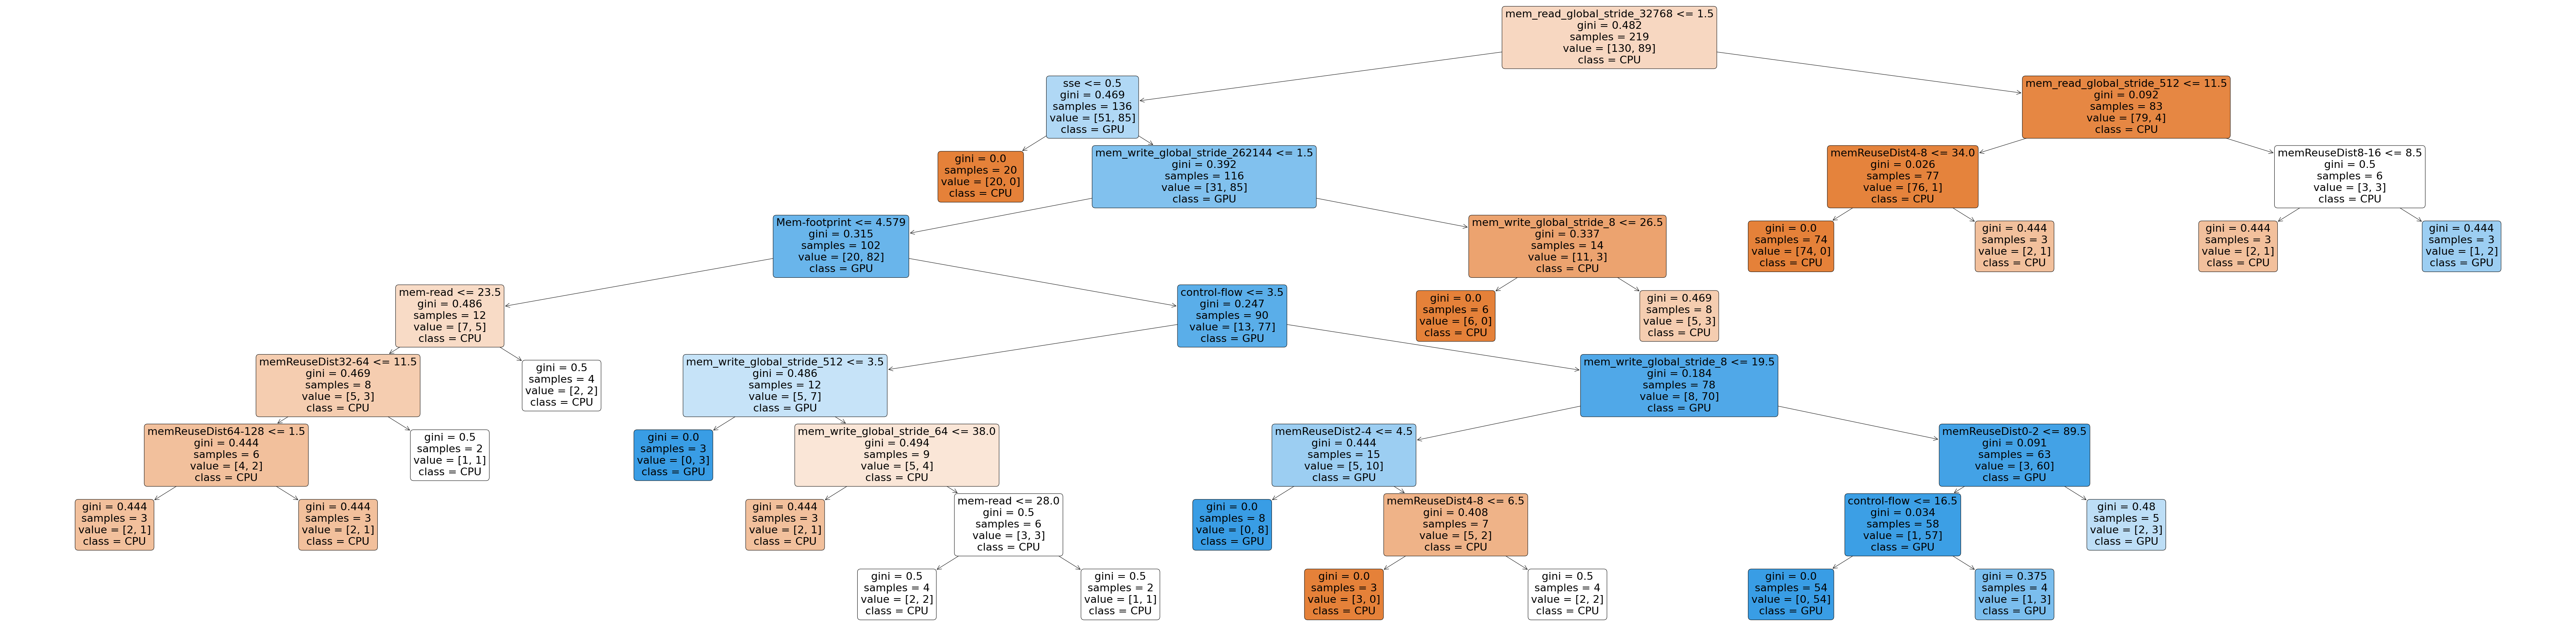

In [9]:
plt.figure(figsize=(120,30))
plot_tree(clf_dt, filled=True, rounded=True,class_names=["CPU","GPU"],feature_names=X.columns)

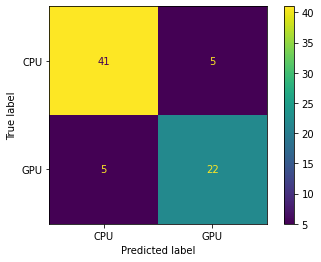

In [10]:
plot_confusion_matrix(clf_dt,X_test,y_test,display_labels=["CPU","GPU"])


# Cost Complexity Pruning Part 1: Visualize alpha

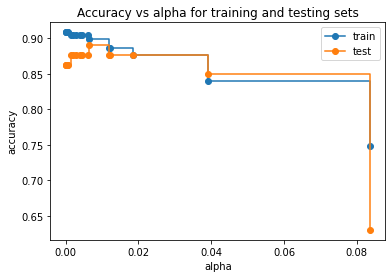

In [11]:
path = clf_dt.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] #exclude max value of alpha (root node)

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train,y_train)
    clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts] 
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o",label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o",label="test",drawstyle="steps-post")
ax.legend()
plt.show()    

# Cost Complexity Pruning Part 2: Cross Validation For Finding the Best Alpha

<AxesSubplot:xlabel='alpha'>

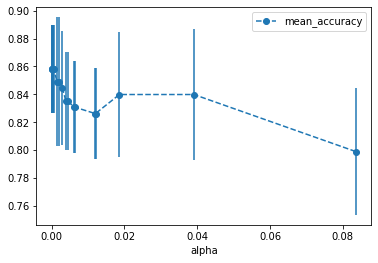

In [12]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train,cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy','std'])

alpha_results.plot(x='alpha',y='mean_accuracy',yerr='std',marker='o',linestyle='--')

In [13]:
alpha_results[(alpha_results['alpha'] < 0.02)]

alpha  mean_accuracy       std
0   0.000000       0.858245  0.031323
1   0.000000       0.858245  0.031323
2   0.000000       0.858245  0.031323
3   0.000381       0.858245  0.031323
4   0.000381       0.858245  0.031323
5   0.000507       0.858245  0.031323
6   0.001522       0.848943  0.046382
7   0.002126       0.848943  0.046382
8   0.002926       0.844397  0.041075
9   0.003914       0.835307  0.035422
10  0.004403       0.835307  0.035422
11  0.006159       0.830761  0.032860
12  0.006342       0.830761  0.032860
13  0.011933       0.826216  0.032714
14  0.012057       0.826216  0.032714
15  0.018626       0.839852  0.044812

In [14]:
ideal_ccp_alpha = 0.006159

clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)
clf_dt_pruned.score(X,y)

0.8972602739726028

In [31]:
clf_dt_pruned.score(X_test,y_test)

0.8767123287671232

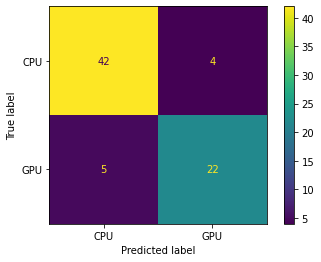

In [15]:
 plot_confusion_matrix(clf_dt_pruned,X_test,y_test,display_labels=["CPU","GPU"])

[Text(1240.0, 764.4375, 'mem_read_global_stride_32768 <= 1.5\ngini = 0.482\nsamples = 219\nvalue = [130, 89]\nclass = CPU'),
 Text(744.0, 662.5125, 'sse <= 0.5\ngini = 0.469\nsamples = 136\nvalue = [51, 85]\nclass = GPU'),
 Text(496.0, 560.5875, 'gini = 0.0\nsamples = 20\nvalue = [20, 0]\nclass = CPU'),
 Text(992.0, 560.5875, 'mem_write_global_stride_262144 <= 1.5\ngini = 0.392\nsamples = 116\nvalue = [31, 85]\nclass = GPU'),
 Text(744.0, 458.66249999999997, 'Mem-footprint <= 4.579\ngini = 0.315\nsamples = 102\nvalue = [20, 82]\nclass = GPU'),
 Text(496.0, 356.7375, 'gini = 0.486\nsamples = 12\nvalue = [7, 5]\nclass = CPU'),
 Text(992.0, 356.7375, 'control-flow <= 3.5\ngini = 0.247\nsamples = 90\nvalue = [13, 77]\nclass = GPU'),
 Text(496.0, 254.8125, 'mem_write_global_stride_512 <= 3.5\ngini = 0.486\nsamples = 12\nvalue = [5, 7]\nclass = GPU'),
 Text(248.0, 152.88750000000005, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = GPU'),
 Text(744.0, 152.88750000000005, 'gini = 0.494\nsamp

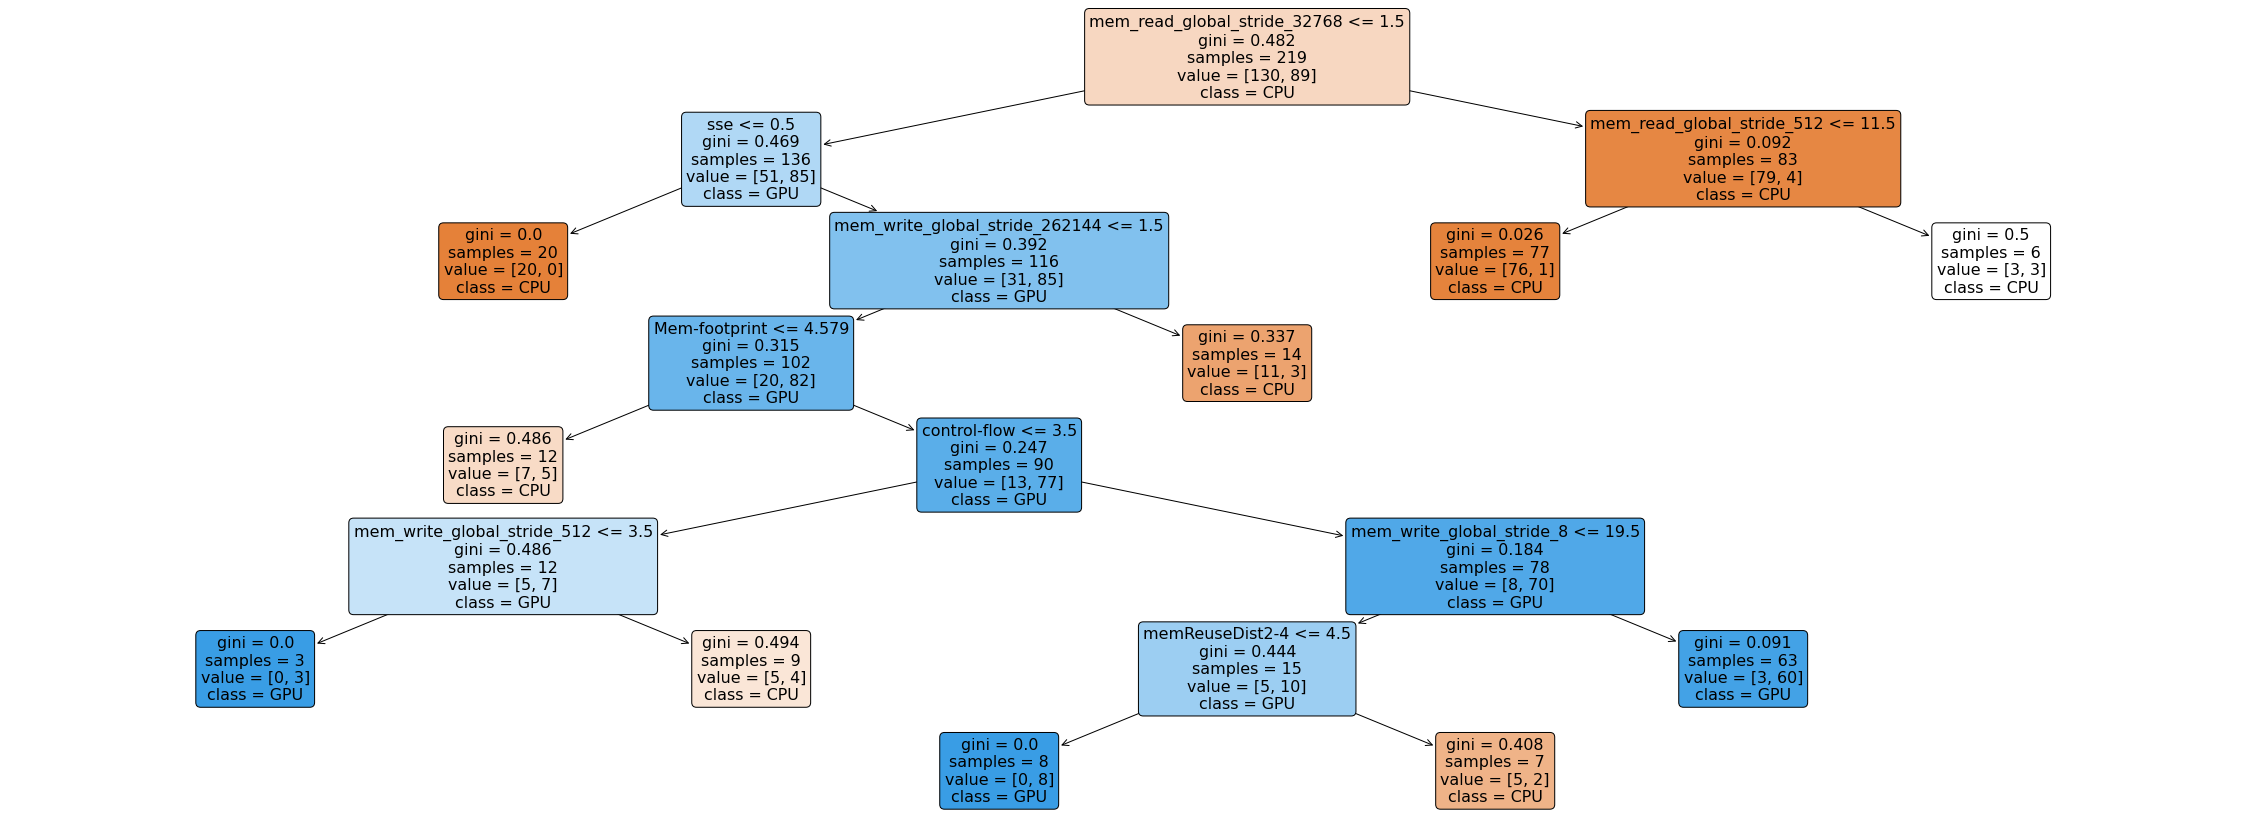

In [16]:
plt.figure(figsize=(40,15))
plot_tree(clf_dt_pruned,filled=True,rounded=True,class_names=["CPU","GPU"],feature_names=X.columns)

# Model 2: Coefficients Included


In [17]:
X2 = df.drop(['APPLICATION NAME dataset','arch1','Issue-width1','SIMD-width','cores1','Mem_BW1','arch2','Issue-width2','Num_SMs','cores2','Mem_bw2','ILP rate','itod','mRD1k-32k','mRD32k-oo','mrgs32k-oo','Coef-IW','Max-su-threads','Cpu-EDP','threads','Gpu-EDP','WG','cpu0-gpu1'],axis='columns').copy()
y2 = df['cpu0-gpu1'].copy()


In [18]:
X2['mem-read'] = X2['mem-read'].astype(int) 
X2['mem-write'] = X2['mem-write'].astype(int) 
X2['control-flow'] = X2['control-flow'].astype(int) 
X2['arithmetic'] = X2['arithmetic'].astype(int)
X2['floating-point'] = X2['floating-point'].astype(int) 
X2['stack'] = X2['stack'].astype(int) 
X2['shift'] = X2['shift'].astype(int) 
X2['string'] = X2['string'].astype(int) 
X2['sse'] = X2['sse'].astype(int)
X2['system'] = X2['system'].astype(int) 
X2['nop'] = X2['nop'].astype(int) 
X2['other'] = X2['other'].astype(int) 
#X.head(15)

X2['cold-references'] = X2['cold-references'].astype(int)
X2['memReuseDist0-2'] = X2['memReuseDist0-2'].astype(int) 
X2['memReuseDist2-4'] = X2['memReuseDist2-4'].astype(int) 
X2['memReuseDist4-8'] = X2['memReuseDist4-8'].astype(int) 
X2['memReuseDist8-16'] = X2['memReuseDist8-16'].astype(int) 
X2['memReuseDist16-32'] = X2['memReuseDist16-32'].astype(int) 
X2['memReuseDist32-64'] = X2['memReuseDist32-64'].astype(int) 
X2['memReuseDist64-128'] = X2['memReuseDist64-128'].astype(int) 
X2['memReuseDist128-256'] = X2['memReuseDist128-256'].astype(int) 
X2['memReuseDist256-512'] = X2['memReuseDist256-512'].astype(int) 
X2['memReuseDist512-1k'] = X2['memReuseDist512-1k'].astype(int) 
X2['memReuseDist1k-2k'] = X2['memReuseDist1k-2k'].astype(int) 
X2['memReuseDist2k-4k'] = X2['memReuseDist2k-4k'].astype(int) 
X2['memReuseDist4k-8k'] = X2['memReuseDist4k-8k'].astype(int) 
X2['memReuseDist8k-16k'] = X2['memReuseDist8k-16k'].astype(int) 
X2['memReuseDist16k-32k'] = X2['memReuseDist16k-32k'].astype(int) 
X2['memReuseDist32k-64k'] = X2['memReuseDist32k-64k'].astype(int) 
X2['memReuseDist64k-128k'] = X2['memReuseDist64k-128k'].astype(int) 
X2['memReuseDist128k-256k'] = X2['memReuseDist128k-256k'].astype(int) 
X2['memReuseDist256k-00'] = X2['memReuseDist256k-00'].astype(int) 
#X

X2['mem_read_global_stride_0'] = X2['mem_read_global_stride_0'].astype(int) 
X2['mem_read_global_stride_8'] = X2['mem_read_global_stride_8'].astype(int) 
X2['mem_read_global_stride_64'] = X2['mem_read_global_stride_64'].astype(int) 
X2['mem_read_global_stride_512'] = X2['mem_read_global_stride_512'].astype(int) 
X2['mem_read_global_stride_4096'] = X2['mem_read_global_stride_4096'].astype(int) 
X2['mem_read_global_stride_32768'] = X2['mem_read_global_stride_32768'].astype(int) 
X2['mem_read_global_stride_262144'] = X2['mem_read_global_stride_262144'].astype(int) 

X2['mem_write_global_stride_0'] = X2['mem_write_global_stride_0'].astype(int) 
X2['mem_write_global_stride_8'] = X2['mem_write_global_stride_8'].astype(int) 
X2['mem_write_global_stride_64'] = X2['mem_write_global_stride_64'].astype(int) 
X2['mem_write_global_stride_512'] = X2['mem_write_global_stride_512'].astype(int) 
X2['mem_write_global_stride_4096'] = X2['mem_write_global_stride_4096'].astype(int) 
X2['mem_write_global_stride_32768'] = X2['mem_write_global_stride_32768'].astype(int) 
X2['mem_write_global_stride_262144'] = X2['mem_write_global_stride_262144'].astype(int) 


In [19]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,random_state=42)

In [20]:
clf_dt2 = DecisionTreeClassifier(random_state=42)
clf_dt2 = clf_dt2.fit(X2_train, y2_train)
clf_dt2.score(X2,y2)

0.9691780821917808

In [21]:
clf_dt2.score(X2_test,y2_test)

0.9178082191780822

[Text(4074.5625, 1556.6727272727271, 'mem_read_global_stride_32768 <= 1.5\ngini = 0.482\nsamples = 219\nvalue = [130, 89]\nclass = CPU'),
 Text(2662.125, 1408.418181818182, 'sse <= 0.5\ngini = 0.469\nsamples = 136\nvalue = [51, 85]\nclass = GPU'),
 Text(2476.125, 1260.1636363636362, 'gini = 0.0\nsamples = 20\nvalue = [20, 0]\nclass = CPU'),
 Text(2848.125, 1260.1636363636362, 'memReuseDist256k-00 <= 2.0\ngini = 0.392\nsamples = 116\nvalue = [31, 85]\nclass = GPU'),
 Text(1418.25, 1111.909090909091, 'Mem-footprint <= 4.579\ngini = 0.315\nsamples = 102\nvalue = [20, 82]\nclass = GPU'),
 Text(744.0, 963.6545454545454, 'Coef-cores <= 4.114\ngini = 0.486\nsamples = 12\nvalue = [7, 5]\nclass = CPU'),
 Text(558.0, 815.4, 'Coef-BW <= 3.519\ngini = 0.469\nsamples = 8\nvalue = [3, 5]\nclass = GPU'),
 Text(372.0, 667.1454545454545, 'Coef-cores <= 2.743\ngini = 0.48\nsamples = 5\nvalue = [3, 2]\nclass = CPU'),
 Text(186.0, 518.890909090909, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = GPU'),


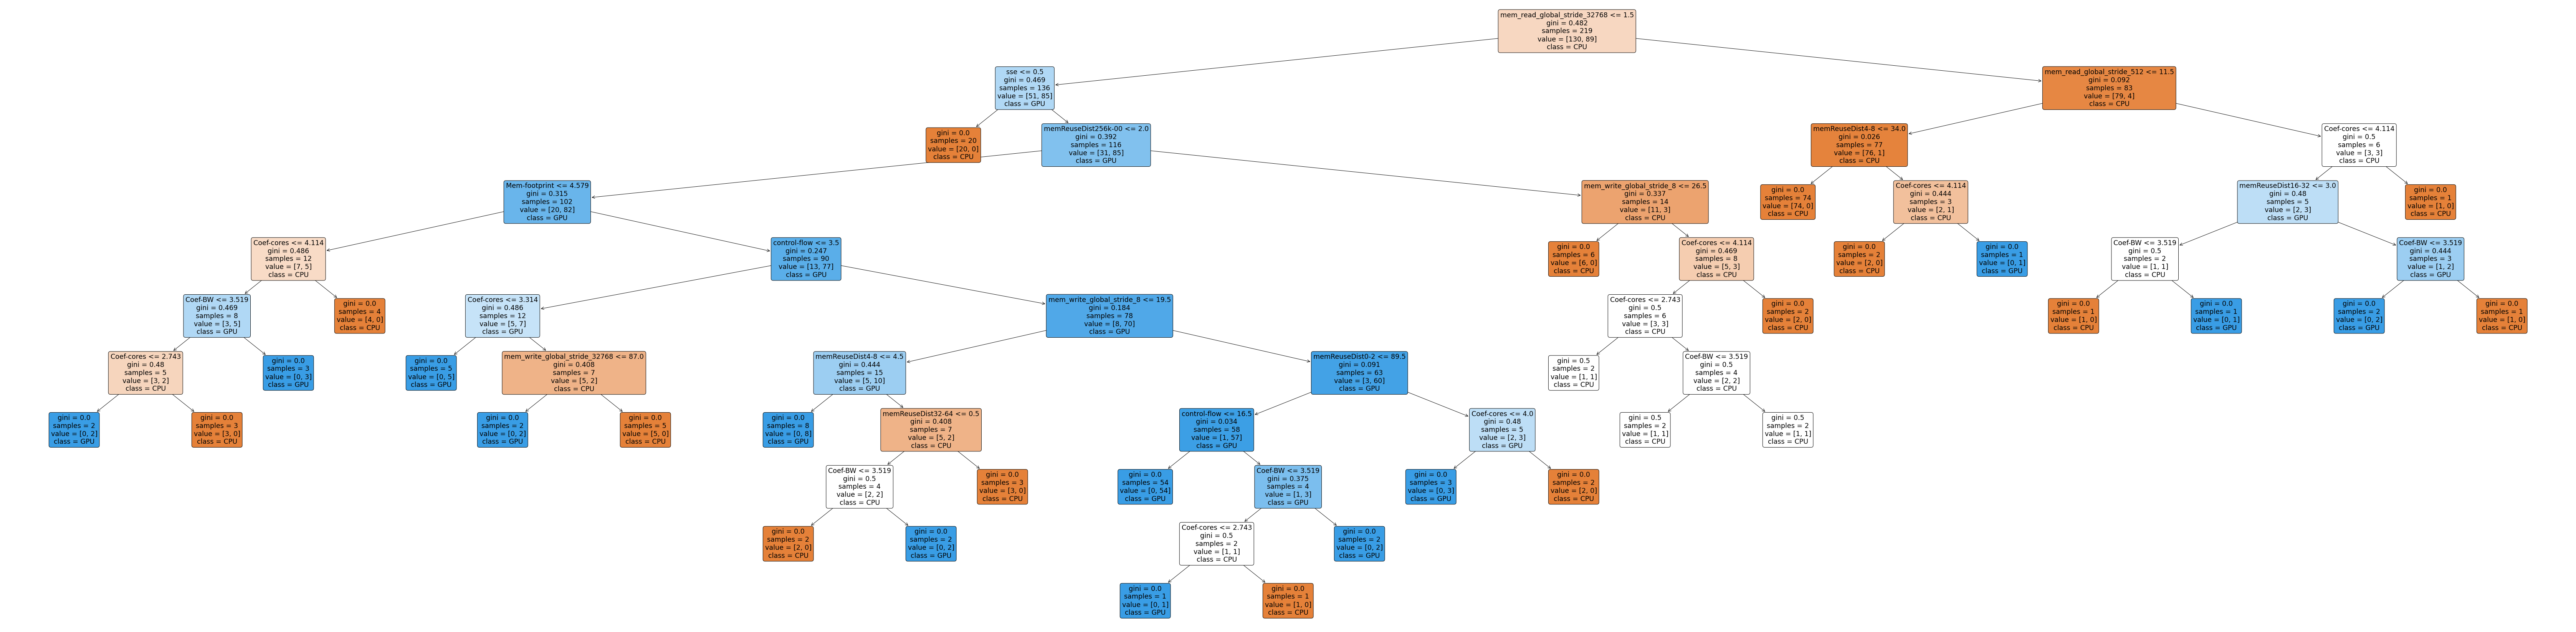

In [22]:
plt.figure(figsize=(120,30))
plot_tree(clf_dt2, filled=True, rounded=True,class_names=["CPU","GPU"],feature_names=X2.columns)

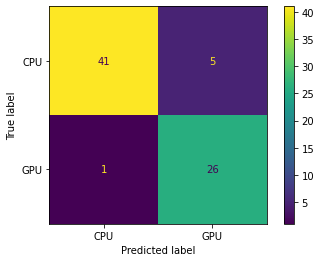

In [23]:
plot_confusion_matrix(clf_dt2,X2_test,y2_test,display_labels=["CPU","GPU"])


Ας κάνουμε Cross-Validation και pruning ευελπιστώντας ότι θα πετύχουμε καλύτερη ακρίβεια.

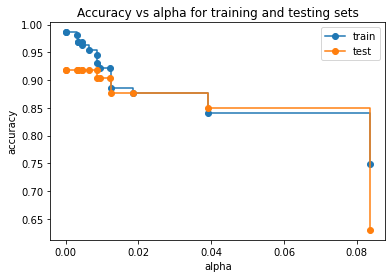

In [24]:
path = clf_dt2.cost_complexity_pruning_path(X2_train,y2_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] #exclude max value of alpha (root node)

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_dt.fit(X2_train,y2_train)
    clf_dts.append(clf_dt)

train_scores = []
test_scores  = []
    
train_scores = [clf_dt.score(X2_train, y2_train) for clf_dt in clf_dts] 
test_scores = [clf_dt.score(X2_test, y2_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o",label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o",label="test",drawstyle="steps-post")
ax.legend()
plt.show()    

<AxesSubplot:xlabel='alpha'>

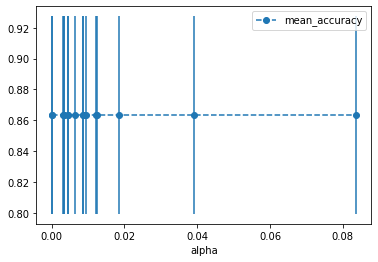

In [25]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt2, X2_train, y2_train,cv=10)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy','std'])

alpha_results.plot(x='alpha',y='mean_accuracy',yerr='std',marker='o',linestyle='--')

In [26]:
alpha_results[(alpha_results['alpha'] < 0.08)]

alpha  mean_accuracy       std
0   0.000000        0.86342  0.063979
1   0.000000        0.86342  0.063979
2   0.002992        0.86342  0.063979
3   0.003425        0.86342  0.063979
4   0.003425        0.86342  0.063979
5   0.004403        0.86342  0.063979
6   0.004507        0.86342  0.063979
7   0.006523        0.86342  0.063979
8   0.008559        0.86342  0.063979
9   0.008562        0.86342  0.063979
10  0.009513        0.86342  0.063979
11  0.012057        0.86342  0.063979
12  0.012487        0.86342  0.063979
13  0.018626        0.86342  0.063979
14  0.039086        0.86342  0.063979

In [27]:
ideal_ccp_alpha = 0.039086

clf_dt_pruned2 = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned2 = clf_dt_pruned2.fit(X2_train, y2_train)
clf_dt_pruned2.score(X2,y2)

0.8767123287671232

In [28]:
clf_dt_pruned2.score(X2_test,y2_test)

0.8767123287671232

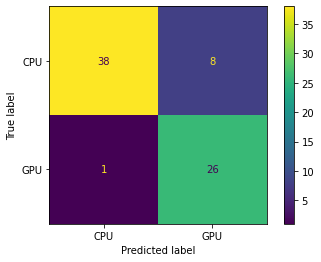

In [29]:
 plot_confusion_matrix(clf_dt_pruned2,X2_test,y2_test,display_labels=["CPU","GPU"])

[Text(4017.6000000000004, 1426.95, 'mem_read_global_stride_32768 <= 1.5\ngini = 0.482\nsamples = 219\nvalue = [130, 89]\nclass = CPU'),
 Text(2678.4, 1019.25, 'sse <= 0.5\ngini = 0.469\nsamples = 136\nvalue = [51, 85]\nclass = GPU'),
 Text(1339.2, 611.55, 'gini = 0.0\nsamples = 20\nvalue = [20, 0]\nclass = CPU'),
 Text(4017.6000000000004, 611.55, 'memReuseDist256k-00 <= 2.0\ngini = 0.392\nsamples = 116\nvalue = [31, 85]\nclass = GPU'),
 Text(2678.4, 203.8499999999999, 'gini = 0.315\nsamples = 102\nvalue = [20, 82]\nclass = GPU'),
 Text(5356.8, 203.8499999999999, 'gini = 0.337\nsamples = 14\nvalue = [11, 3]\nclass = CPU'),
 Text(5356.8, 1019.25, 'gini = 0.092\nsamples = 83\nvalue = [79, 4]\nclass = CPU')]

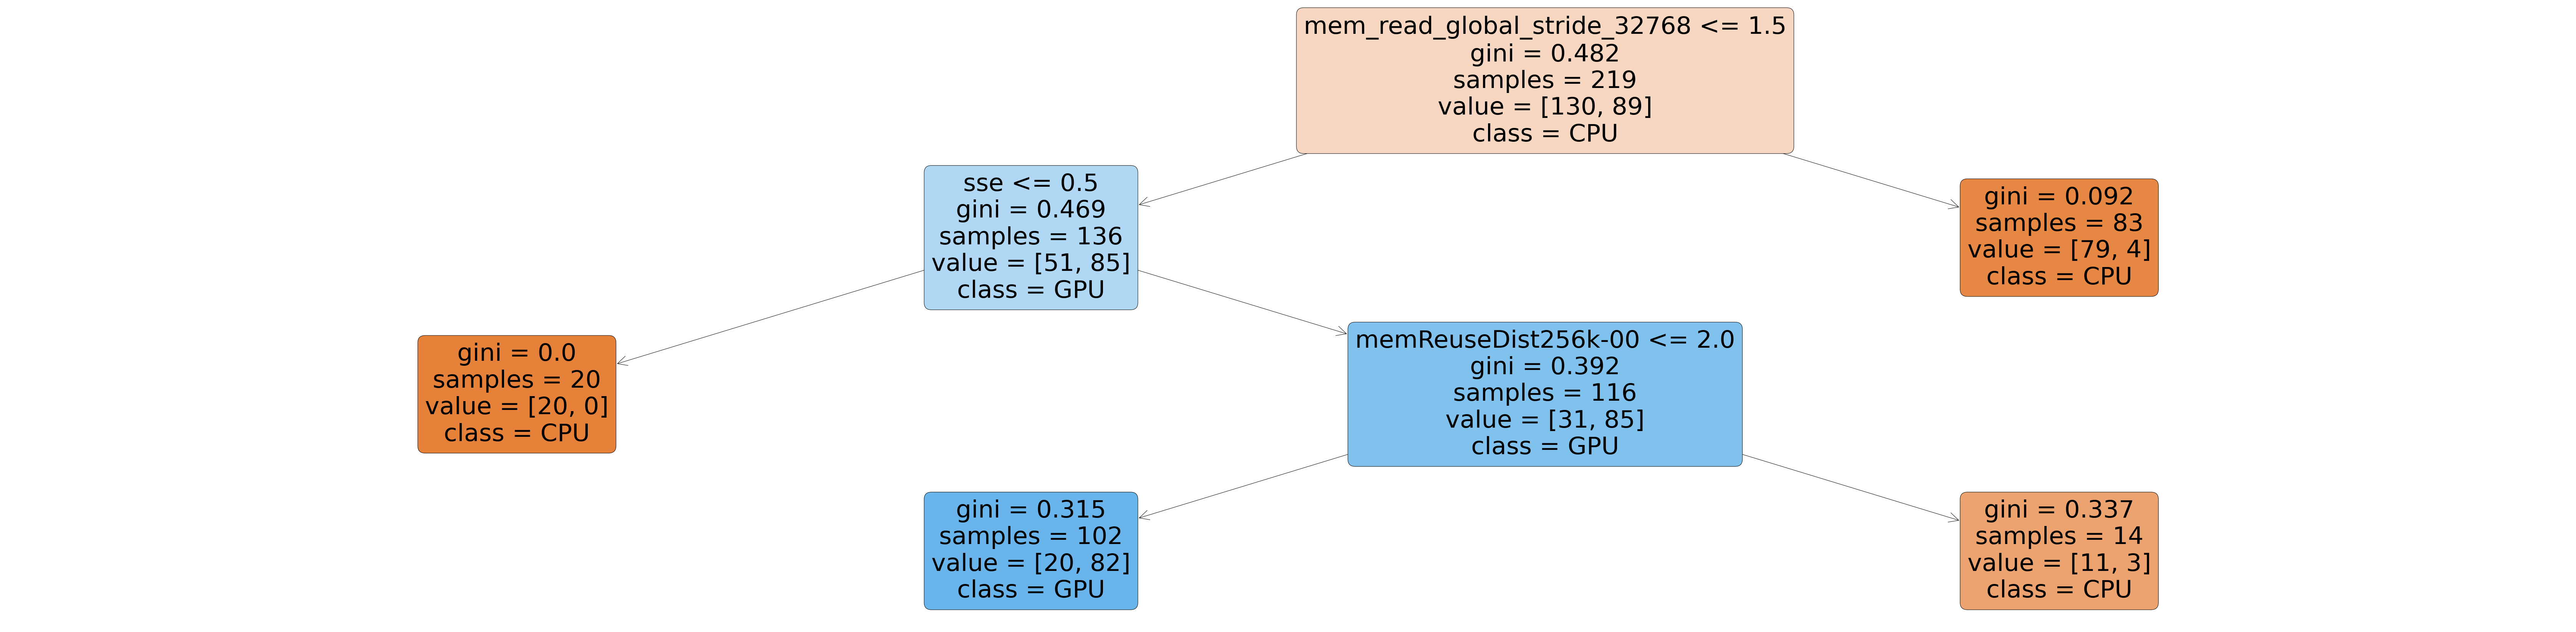

In [30]:
plt.figure(figsize=(120,30))
plot_tree(clf_dt_pruned2, filled=True, rounded=True,class_names=["CPU","GPU"],feature_names=X2.columns)

Το **model 2** είναι το μοντέλο με την καλύτερη ακρίβεια